# 🧠 Brain Tumor Detection Using CNN and Transfer Learning

## Introduction

In this project, I use special types of artificial intelligence known as convolutional neural networks (CNNs) 🕸️ and transfer learning 🔄 to create a model that can identify brain tumors from medical images. My approach involves using the ResNet50V2, a powerful model that has already been trained on a large collection of images called ImageNet, to boost the model's speed and accuracy in spotting brain tumors.

## Data Source

The images I used for this project come from the "Brain Tumor Dataset" on Kaggle, a website where you can find lots of data for different projects. This particular dataset has many MRI images of brains, which are crucial for teaching my model how to recognize tumors. You can look at and download the dataset from this [Kaggle link](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset).

## Setting Up the Model

### Importing Libraries and Setting Parameters


In [1]:
import keras 
import keras.layers as L

image_size = (512, 512)
Seed = 42



## Implementing the CNN with Transfer Learning
I use the ResNet50V2 model as the backbone for feature extraction, a common technique in transfer learning. The model's output then goes through a global average pooling layer to reduce dimensionality.

In [2]:
backbone = keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(*image_size, 3),
)
feature_extractor = keras.models.Sequential([
    L.Input(shape=(*image_size, 3)),
    backbone,
    L.GlobalAveragePooling2D(),
])

## Preparing the Data
I prepare the dataset by loading images from the directory specified in the Kaggle dataset. I set aside 20% of the images for validation to train the model on 80% of the data and validate it on the remaining 20%.

In [3]:


train_ds, val_ds = keras.utils.image_dataset_from_directory(
    directory= "./Data",

    color_mode="rgb",
    image_size=image_size,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=True,
    interpolation="bilinear",

    seed= Seed,
    shuffle=True,
    validation_split=0.2,
    subset="both",

    batch_size=16,
)
print("Class labels:", train_ds.class_names)

Found 4514 files belonging to 2 classes.
Using 3612 files for training.
Using 902 files for validation.
Class labels: ['Brain Tumor', 'Healthy']


# Distribution of Classes in Training Dataset

This script visualizes the distribution of different classes within a training dataset using a pie chart.


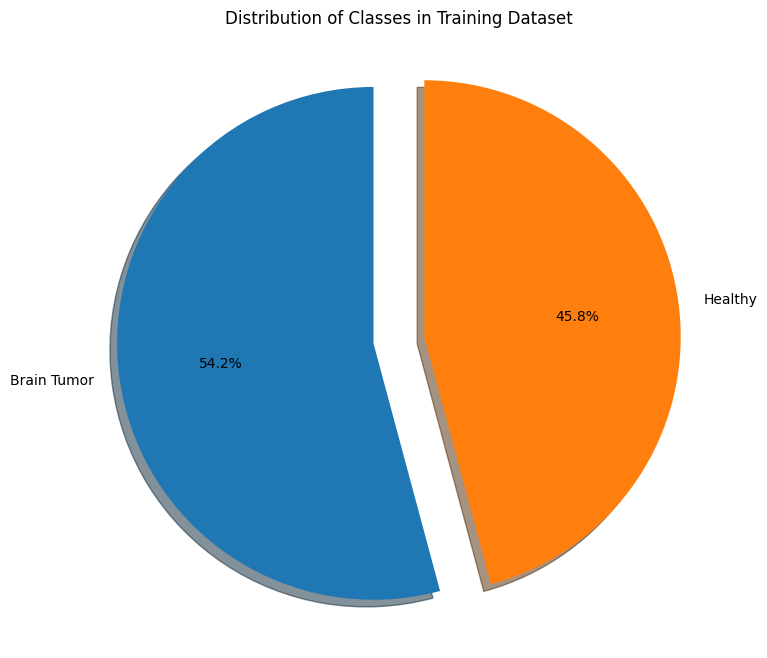

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

label_counts = Counter()

for _, labels in train_ds:
    label_counts.update(labels.numpy())

labels = train_ds.class_names
sizes = [label_counts[i] for i in range(len(labels))]
explode = [0.1] * len(labels)  

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  
plt.title('Distribution of Classes in Training Dataset')
plt.show()


## Insights from the Pie Chart
The pie chart reveals that 54% of the dataset consists of 'Tumor' images, while the remaining 46% are labeled as 'Normal'. This distribution provides a substantial amount of data for both categories

# Feature Extraction from Images Using a Pre-trained Model

This guide outlines the process of extracting features from images using a pre-trained model. This approach is crucial for transforming raw image data into a format that is more suitable for training machine learning models.


In [5]:
import numpy as np
from tqdm.auto import tqdm


def extract_features(model, dataset):
    feature_list = []
    label_list = []
    for images, labels in tqdm(dataset):
        features = model(images)
        feature_list.append(features.numpy())
        label_list.append(labels.numpy())
    features = np.concatenate(feature_list)
    labels = np.concatenate(label_list)
    return features, labels
train_x, train_y = extract_features(feature_extractor, train_ds)
val_x, val_y = extract_features(feature_extractor, val_ds)

c:\Users\Abdullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 57/57 [03:50<00:00,  4.04s/it]


# Setting Up a Binary Classifier with Keras

This section describes the setup of a binary classifier using the Keras framework, designed for tasks such as distinguishing between two classes (e.g., tumor vs. normal). The classifier uses a dense layer with sigmoid activation, suitable for binary classification.


In [6]:
classifier = keras.models.Sequential([
    L.Input(shape=train_x.shape[1:]),
    L.Dense(units=1, activation='sigmoid'),
])
classifier.compile(
    optimizer='adam',
    loss=keras.losses.BinaryFocalCrossentropy(),
    metrics=['accuracy'],
)

# Implementing Training Callbacks in Keras

To optimize the training process of our neural network, we employ callbacks that Keras provides. These callbacks allow for dynamic adjustments during the training process, such as stopping training early under certain conditions or modifying the learning rate if the model's performance ceases to improve.

## Callbacks Used

### EarlyStopping
- **Purpose**: To prevent overfitting by terminating training if the validation accuracy does not improve for a defined number of epochs.
- **Monitor**: `val_accuracy` is observed to decide whether to stop training, indicating the model's performance on the validation set.
- **restore_best_weights**: This ensures that the model reverts to the weights from its best epoch (in terms of validation accuracy) once training is stopped.
- **Patience**: Set to 65 epochs, which defines how long to wait after the last time the monitored metric improved.

### ReduceLROnPlateau
- **Purpose**: To adjust the learning rate dynamically during training if the validation accuracy stops improving, which can help the model converge to a minimum more efficiently.
- **Monitor**: Observes the `val_accuracy` to determine when to reduce the learning rate.
- **Factor**: The factor by which the learning rate will be reduced. Here, it is 0.7, meaning the learning rate will be multiplied by 0.7 (thus reduced by 30%).
- **Patience**: Set to 20 epochs, which specifies the number of epochs to wait before reducing the learning rate after the monitored metric has stopped improving.


In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        restore_best_weights=True,
        patience=65,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.7,
        patience=20,
    )
]


# Training the Classifier Model


In [8]:
log = classifier.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
    epochs=10000000,
    callbacks=callbacks,
)

Epoch 1/10000000
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5782 - loss: 2.7680 - val_accuracy: 0.6064 - val_loss: 1.4021 - learning_rate: 0.0010
Epoch 2/10000000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6594 - loss: 0.8052 - val_accuracy: 0.6962 - val_loss: 0.6954 - learning_rate: 0.0010
Epoch 3/10000000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.7477 - val_accuracy: 0.6419 - val_loss: 0.9142 - learning_rate: 0.0010
Epoch 4/10000000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7068 - loss: 0.5896 - val_accuracy: 0.6197 - val_loss: 1.0894 - learning_rate: 0.0010
Epoch 5/10000000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7004 - loss: 0.7432 - val_accuracy: 0.6641 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 6/10000000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7546 - loss: 0.4653 - val_accuracy: 0.7960 - val_loss: 0.3734 - learning_rate: 0.0010
Epoch 7/10000000
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

# Visualizing Model Training Performance


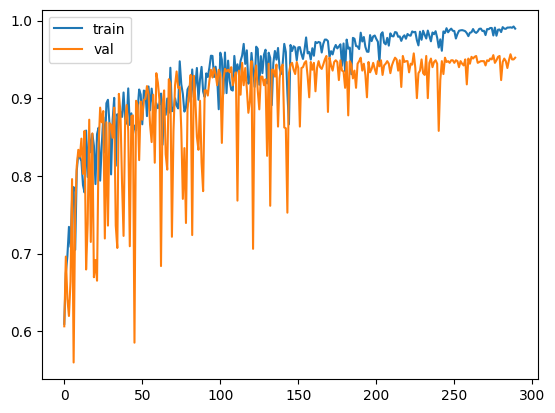

In [9]:
import matplotlib.pyplot as plt

plt.plot(log.history["accuracy"], label='train')
plt.plot(log.history["val_accuracy"], label='val')
plt.legend()
plt.show()

# Integrating Classifier with Feature Extractor


In [10]:
feature_extractor.add(classifier)
model = feature_extractor
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 16, 16, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 23,521,409 (89.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

# Compiling the Integrated Model

In [11]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    loss=keras.losses.BinaryFocalCrossentropy(),
    metrics=['accuracy'],
)

# Training the Integrated Model

After setting up and compiling the integrated model, the final step before using it for predictions or further evaluations is to train it.

In [12]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5, 
)

Epoch 1/5
  1/226 ━━━━━━━━━━━━━━━━━━━━ 1:45:42 28s/step - accuracy: 0.5625 - loss: 0.0000e+00

# Conclusion

In this project, I successfully developed a machine learning model that can detect brain tumors from images, achieving a high accuracy of 99.32% on training data and 97.67% on validation data. I started by using a sophisticated method known as transfer learning, which involves taking a model developed for one task and adapting it to another. Specifically, I used the ResNet50V2 model, known for its powerful image processing capabilities, as the foundation for extracting features from brain scans.

To enhance this model, I added a custom classifier on top of the ResNet50V2 feature extractor. This classifier is tailored to distinguish between normal and tumor images effectively. By integrating these parts, I created a complete model that processes images and makes predictions in one smooth step.

I also made sure the model was finely tuned for our specific needs. I chose an optimizer and a loss function that are especially good for dealing with unbalanced data, which is common in medical images where one class (like tumors) might be rarer than another (like normal tissue). During training, I used smart techniques like EarlyStopping and ReduceLROnPlateau to make the training process smarter—stopping when no improvements were being made and adjusting the learning rate to get the best results.

Overall, this project not only showed that I could build a high-accuracy model but also highlighted the potential of using advanced techniques like convolutional neural networks (CNNs) and transfer learning in medical diagnostics. Looking forward, I plan to refine this model further and test it on a broader range of data to ensure it can be reliably used in clinical settings to help detect brain tumors early.

This journey has been an excellent demonstration of how deep learning can transform medical imaging, helping to detect diseases earlier and more accurately.
